In [2]:
import sys
sys.path.append("..")

import numpy as np
import glob
import matplotlib.pyplot as plt
import pandas as pd
#from spiralcutter_advanced.libs.spiral_funcs import *
from spiralcutter_advanced.libs.twod_funcs_mod import *
from spiralcutter_advanced.libs.profile_funcs import *
from spiralcutter_advanced.libs.helper_funcs import *
from scipy.optimize import curve_fit
from astropy.io import fits

/tmp/ipykernel_2670/3004337771.py:49: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(linear, r_arr, sk_arr, sigma = ske_arr)
/tmp/ipykernel_2670/3004337771.py:103: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_2670/3004337771.py:113: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


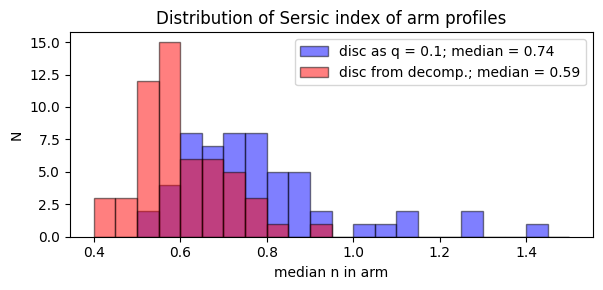

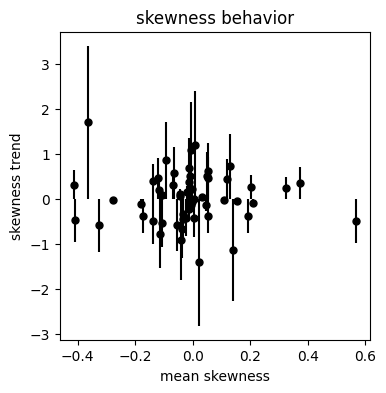

In [3]:
def linear(x, a, b):
    return a * x + b

gals = []
gal_paths = glob.glob("../galaxies_images/*")
for path in gal_paths:
    gals.append(path.split("/")[-1])
gals = np.sort(gals)

#chisqs_list = []

n_all = [[], [], []]
col_all = [[], [], []]
phi_all = [[], [], []]
l_all = [[], [], []]
sk_all = [[], [], []]
skt_all = [[], [], []]
skte_all = [[], [], []]
fs = ["profiles_precise.dat", "profiles_precise_masked.dat", "profiles_precise_total.dat"]

for i in [0, 1, 2]:
    nl = n_all[i]
    coll = col_all[i]
    phil = phi_all[i]
    skl = sk_all[i]
    sktl = skt_all[i]
    sktel = skte_all[i]
    ll = l_all[i]
    for gal in gals:
        path_res = f"../galaxies_images/{gal}/spiral_params/{fs[i]}"
    
        with open(path_res, "r") as file:
            for line in file:
                col, n = line.split()[0:2]

                n = float(n)
                
                r_this = line.split("[")[1].split("]")[0]
                r_arr = np.array(r_this.split()).astype(float)
                
                sk_this = line.split("[")[2].split("]")[0]
                sk_arr = np.array(sk_this.split()).astype(float)
                
                ske_this = line.split("[")[3].split("]")[0]
                ske_arr = np.array(ske_this.split()).astype(float)
                
                sk_mean = np.nanmedian(sk_arr)
                try:
                    popt, pcov = curve_fit(linear, r_arr, sk_arr, sigma = ske_arr)
                    perr = np.sqrt(np.diag(pcov))
                    rmin = np.min(r_arr)
                    rmax = np.max(r_arr)
                    skmin = linear(rmin, *popt)
                    skmax = linear(rmax, *popt)
                    skt = skmax - skmin
                    skte = np.abs(popt[0] * (rmax - rmin))
                except Exception:
                    skt = np.nan
                    skte = np.nan
                
                arm_str = fits.getdata(f"../galaxies_images/{gal}/str_arms_azavg/arm_str_{col}.fits")
                lpsi = len(arm_str[0, :]) / 2

                phil.append(lpsi)
                coll.append(col)
                nl.append(n)
                skl.append(sk_mean)
                sktl.append(skt)
                sktel.append(skte)
                ll.append(lpsi)
            
    phi_all[i] = np.array(phil)
    col_all[i] = np.array(coll)
    n_all[i] = np.array(nl)
    sk_all[i] = np.array(skl)
    skt_all[i] = np.array(sktl)
    skte_all[i] = np.array(sktel)
    l_all[i] = np.array(ll)
    
#fig, ax = plt.subplots(figsize=[6,6])
#ax.hist(n_all[0], np.arange(0.1, 2.1, 0.1), alpha = 0.2, label = f"base, median = {np.round(np.median(n_all[0]), 3)}")
#ax.hist(n_all[1], np.arange(0.1, 2.1, 0.1), alpha = 0.2, label = f"masked, median = {np.round(np.median(n_all[1]), 3)}")
#ax.hist(n_all[2], np.arange(0.1, 2.1, 0.1), alpha = 0.2, label = f"w nonst, median = {np.round(np.median(n_all[2]), 3)}")
#ax.legend(fontsize=8)
#fig.show()

#fig, ax = plt.subplots(figsize=[6,6])
#ax.hist(sk_all[0], np.arange(-1, 1.1, 0.1), alpha = 0.5, label = f"base, median = {np.round(np.median(sk_all[0]), 3)}")
#ax.legend(fontsize=8)
#fig.show()

fig, ax = plt.subplots(figsize=[6,3])
ax.hist(n_all[0][l_all[0] > 180], np.arange(0.4, 1.55, 0.05), alpha = 0.5, edgecolor="k", facecolor="b",
        label = f"disc as q = 0.1; median = {np.round(np.median(n_all[0][l_all[0] > 180]), 2)}")
ax.hist(n_all[1][l_all[1] > 180], np.arange(0.4, 1.55, 0.05), alpha = 0.5, edgecolor="k", facecolor="r",
        label = f"disc from decomp.; median = {np.round(np.median(n_all[1][l_all[1] > 180]), 2)}")
ax.set_xlabel("median n in arm")
ax.set_ylabel("N")
ax.set_title("Distribution of Sersic index of arm profiles")
ax.legend()
fig.tight_layout()
fig.savefig("../images/selected/Sersic_index_distribution", dpi = 300)
fig.show()

fig, ax = plt.subplots(figsize=[4,4])
ax.errorbar(sk_all[0][l_all[0] > 180], skt_all[0][l_all[0] > 180], yerr = skte_all[0][l_all[0] > 180],
            c = "k", ls = "", marker = "o", ms = 5)
ax.set_xlabel("mean skewness")
ax.set_ylabel("skewness trend")
ax.set_title("skewness behavior")
#ax.legend()
#fig.savefig("../images/selected/Sersic_index_distribution")
fig.show()
